In [ ]:
#!pip install ortools

Found existing installation: ortools 7.8.7959
Uninstalling ortools-7.8.7959:
  Would remove:
    /Users/pkumar/.local/lib/python3.6/site-packages/ortools-7.8.7959.dist-info/*
    /Users/pkumar/.local/lib/python3.6/site-packages/ortools/*
Proceed (y/n)? 

In [2]:
import numpy as np
from random import randint
from __future__ import print_function
from ortools.linear_solver import pywraplp
import copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import random
from copy import deepcopy

In [3]:
def create_input_data():
  # Simulate the demand
  num_assets = 10 # total number of offshore locations
  prob_need_maintenance = 0.3 # probability that an asset will require maintenance
  min_staff_needed = 1
  max_staff_needed =16
  need_maintenance =  np.random.uniform(0,1,num_assets)> prob_need_maintenance # np.array[Bool] of size num_asset. True if an asset need maintenance. 
  staff_needed_per_asset = np.multiply(np.random.randint(min_staff_needed, max_staff_needed, num_assets),need_maintenance) # array of intergers representing number of workers needed at a location
  # asset_priority = np.ones(num_assets, dtype = int).tolist() 
  asset_priority = [1,1,2,2,2,1,1,2,1,1]
  # Simulate supply
  capacity_vehicles = [15, 15, 25, 25] 
  mu_staff = 70
  sigma_staff = 20
  min_team_size = 1
  max_team_size = 8
  total_staff = int(np.ceil(np.random.normal(mu_staff, sigma_staff, 1))[0]) # sample number of staffs
  if(total_staff <= 0):
    total_staff = 1
  # Dict to store all input data
  input_data = {}
  input_data['num_assets'] = num_assets
  input_data['need_maintenance'] = need_maintenance.astype(int).tolist()
  input_data['asset_priority'] = asset_priority
  input_data['staff_needed_per_asset'] = staff_needed_per_asset.tolist()
  input_data['capacity_vehicles'] = capacity_vehicles
  input_data['max_team_size'] = max_team_size
  input_data['min_team_size'] = min_team_size
  input_data['total_staff'] = total_staff
  return input_data

In [4]:
def sample_teams(total_staff, min_team_size, max_team_size,staff_needed_per_asset, asset_priority,capacity_vehicles):
  # modify the max_team_size if the demand > supply
  if (total_staff<sum(staff_needed_per_asset)):
    max_team_size = min(max_team_size,int(max_team_size*total_staff/sum(staff_needed_per_asset)))
  else:
    max_team_size = min(max_team_size,int(max_team_size*sum(staff_needed_per_asset)/total_staff))
    total_staff = randint(sum(staff_needed_per_asset),total_staff)
  
  if (max_team_size<1):
    max_team_size = 1
  # print("Max team size:", max_team_size)
  # create splits
  initial_teams = []
  while (True):
    team = randint(min_team_size, max_team_size)
    if (team + sum(initial_teams) > total_staff):
      break
    if (team>0):
      initial_teams.append(team)
  if (total_staff - sum(initial_teams)>0):
    initial_teams.append(total_staff - sum(initial_teams))


  # print("Total staff: ",total_staff)
  # print("Total staff needed", sum(staff_needed_per_asset))
  # print("Staff needed per asset",staff_needed_per_asset)
  # print("Asset priority", asset_priority)
  # print("Initial_teams: ", initial_teams)

  # sort based on priority of locations
  sorted_index_asset_priority = np.argsort(asset_priority).tolist()
  sorted_index_asset_priority = sorted_index_asset_priority[::-1]
  # print("Sorted index", sorted_index_asset_priority)
  # split into main and extra teams
  main_teams = []
  priority = []
  demand = []
  teams_counter = 0
  while (len(initial_teams) > 0 and teams_counter < len(staff_needed_per_asset)):
    staff_needed = staff_needed_per_asset[sorted_index_asset_priority[teams_counter]]
    demand.append(staff_needed)
    priority.append(asset_priority[sorted_index_asset_priority[teams_counter]])
    if (staff_needed == 0):
      main_teams.append([0])
    else:
      teams_per_location = []
      while(staff_needed > 0 and len(initial_teams) > 0):
        index_min = 0
        difference = 999
        for i in range(len(initial_teams)):
          if(abs(staff_needed - initial_teams[i]) < difference):
            index_min = i
            difference = abs(staff_needed - initial_teams[i])
        teams_per_location.append(initial_teams[index_min])
        staff_needed = staff_needed - initial_teams[index_min]
        initial_teams.pop(index_min)
      main_teams.append(teams_per_location)
    teams_counter = teams_counter+1
  while (teams_counter < len(staff_needed_per_asset)):
    main_teams.append([0])
    staff_needed = staff_needed_per_asset[sorted_index_asset_priority[teams_counter]]
    demand.append(staff_needed)
    priority.append(asset_priority[sorted_index_asset_priority[teams_counter]])
    teams_counter = teams_counter+1

  # print("Initial_teams: ", initial_teams)
  while (len(initial_teams)>0):
    random_index = randint(0,len(staff_needed_per_asset)-1)
    if(sum(main_teams[random_index])>0):
      main_teams[random_index].append(initial_teams[0])
      initial_teams.pop(0)
  # print("Priority", priority)
  # print("Demand", demand)
  # print("Teams per location", main_teams)
  # print("Initial_teams: ", initial_teams)
  return demand, priority, main_teams

  # vehicle_loads = bin_packing(main_teams, capacity_vehicles)
  # print("Vehicle loads", vehicle_loads)
  # # find vehicles that fits best the vehicle loads
  # selected_vehicles = []
  # space_left_selected_vehicles = []
  # vehicle_counter = 0
  # while(len(vehicle_loads) > vehicle_counter):
  #   vehicle_load = vehicle_loads[vehicle_counter]
  #   index_min = 0
  #   difference = 25
  #   for i in range(len(capacity_vehicles)):
  #     if(capacity_vehicles[i] - vehicle_load >= 0 and capacity_vehicles[i] - vehicle_load < difference):
  #       difference = capacity_vehicles[i] - vehicle_load
  #       index_min = i
  #   space_left_selected_vehicles.append(difference)    
  #   selected_vehicles.append(capacity_vehicles[index_min])
  #   capacity_vehicles.pop(index_min)
  #   vehicle_counter = vehicle_counter + 1
  # print("Extra_teams: ", initial_teams)
  # print("Main_teams: ", main_teams)
  # print("Selected vehicles", selected_vehicles )
  # print("Space left", space_left_selected_vehicles)
  # teams_counter = 0  
  # while(len(initial_teams) > 0 and teams_counter < len(space_left_selected_vehicles)):
  #   staff_needed = space_left_selected_vehicles[teams_counter]
  #   while(staff_needed > 0 and len(initial_teams) > 0):
  #     index_min = 0
  #     difference = 999
  #     for i in range(len(initial_teams)):
  #       if(abs(staff_needed - initial_teams[i]) < difference):
  #         index_min = i
  #         difference = abs(staff_needed - initial_teams[i])
  #     main_teams.append(initial_teams[index_min])
  #     staff_needed = staff_needed - initial_teams[index_min]
  #     initial_teams.pop(index_min)
  #   teams_counter = teams_counter+1

  # print("Extra_teams: ", initial_teams)
  # print("Main_teams: ", main_teams)
  # print("Selected vehicles", selected_vehicles )
  # print("Space left", space_left_selected_vehicles)
  # print("=============================")
  # return main_teams,selected_vehicles


In [5]:
def bin_packing(weights,bin_capacity):
    data = {}
    data['weights'] = weights
    data['items'] = list(range(len(weights)))
    data['bins'] = list(range(len(bin_capacity)))
    data['bin_capacity'] = bin_capacity
    
    bin_number_list = []
    bin_items_list = []
    bin_weight_list = []

    # Create the mip solver with the CBC backend.
    solver = pywraplp.Solver('bin_packing_mip',pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    # Variables
    # x[i, j] = 1 if item i is packed in bin j.
    x = {}
    for i in data['items']:
        for j in data['bins']:
            x[(i, j)] = solver.IntVar(0, 1, 'x_%i_%i' % (i, j))

    # y[j] = 1 if bin j is used.
    y = {}
    for j in data['bins']:
        y[j] = solver.IntVar(0, 1, 'y[%i]' % j)

    # Constraints
    # Each item must be in exactly one bin.
    for i in data['items']:
        solver.Add(sum(x[i, j] for j in data['bins']) == 1)

    # The amount packed in each bin cannot exceed its capacity.
    for j in data['bins']:
        solver.Add(
            sum(x[(i, j)] * data['weights'][i] for i in data['items']) <= y[j] *
            data['bin_capacity'][j])

    # Objective: minimize the number of bins used.
    solver.Minimize(solver.Sum([y[j] for j in data['bins']]))

    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        for j in data['bins']:
            if y[j].solution_value() == 1:
                bin_items = []
                bin_weight = 0
                for i in data['items']:
                    if x[i, j].solution_value() > 0:
                        bin_items.append(i)
                        bin_weight += data['weights'][i]
                if bin_weight > 0:
                    bin_number_list.append(j)
                    bin_items_list.append(bin_items)
                    bin_weight_list.append(bin_weight)
        return bin_weight_list
    else:
        return bin_weight_list

In [6]:
def cal_pop_cost(total_staff_available, selected_teams, asset_priority, staff_needed_per_asset, capacity_vehicles,penalty_no_team_assigned):
  # cost due to unmet demand per asset
  cost_unmet_demand = 0
  for i in range(len(staff_needed_per_asset)):
    cost_unmet_demand = cost_unmet_demand + 2*asset_priority[i]*max(0,staff_needed_per_asset[i] - sum(selected_teams[i]))
  
  # penalty for having no teams at an asset which need some maintainance
  cost_no_team_assigned = 0
  for i in range(len(staff_needed_per_asset)):
    if (staff_needed_per_asset[i]>0 and sum(selected_teams[i]) == 0):
      cost_no_team_assigned = cost_no_team_assigned + asset_priority[i]*penalty_no_team_assigned

  # cost due to vehicle filling
  # first flatten the list of list
  flat_team_list = []
  for sublist in selected_teams:
    for item in sublist:
        flat_team_list.append(item)    
  vehicle_loads = bin_packing(flat_team_list, capacity_vehicles)
  vehicle_counter = 0
  selected_vehicles = []
  while (len(vehicle_loads) > vehicle_counter):
    vehicle_load = vehicle_loads[vehicle_counter]
    index_min = 0
    difference = 25
    for i in range(len(capacity_vehicles)):
      if(capacity_vehicles[i] - vehicle_load >= 0 and capacity_vehicles[i] - vehicle_load < difference):
        difference = capacity_vehicles[i] - vehicle_load
        index_min = i 
    selected_vehicles.append(capacity_vehicles[index_min])
    capacity_vehicles.pop(index_min)
    vehicle_counter = vehicle_counter + 1
  if(len(vehicle_loads) == 0):
    cost_vehicle = sum(capacity_vehicles)
  else:
    # cost_vehicle = sum(selected_vehicles)
    cost_empty_seat = 0
    for i in range(len(selected_vehicles)):
      cost_empty_seat  = cost_empty_seat + selected_vehicles[i] - vehicle_loads[i]
    cost_vehicle = sum(vehicle_loads) + 4*cost_empty_seat 

  #cost of unused staff
  cost_unused_staff = 0.25*(total_staff_available - sum(flat_team_list))
  cost = cost_unused_staff + cost_no_team_assigned + cost_unmet_demand + cost_vehicle
  return cost

In [7]:
def vehicle_utilization(selected_teams, capacity_vehicles):
  flat_team_list = []
  for sublist in selected_teams:
    for item in sublist:
        flat_team_list.append(item)    
  vehicle_loads = bin_packing(flat_team_list, capacity_vehicles)
  vehicle_counter = 0
  selected_vehicles = []
  while (len(vehicle_loads) > vehicle_counter):
    vehicle_load = vehicle_loads[vehicle_counter]
    index_min = 0
    difference = 25
    for i in range(len(capacity_vehicles)):
      if(capacity_vehicles[i] - vehicle_load >= 0 and capacity_vehicles[i] - vehicle_load < difference):
        difference = capacity_vehicles[i] - vehicle_load
        index_min = i 
    selected_vehicles.append(capacity_vehicles[index_min])
    capacity_vehicles.pop(index_min)
    vehicle_counter = vehicle_counter + 1
  if(len(vehicle_loads) == 0):
    return capacity_vehicles
  else:
    return vehicle_loads

In [8]:
def select_mating_pool(k, selection_prob, population, cost, num_parents_mating):
  parents = []
  #k-tournament selection
  while (len(parents)< num_parents_mating and len(population)>k):
    k_samples = []
    cost_samples = []
    while (len(k_samples)<=k): # select randomly k individuals
      random_index = random.randrange(len(population))
      if (random_index not in k_samples):
        k_samples.append(random_index)
        cost_samples.append(cost[random_index])
    index_min_cost = min(range(len(cost_samples)), key=cost_samples.__getitem__)
    if (random.uniform(0,1) > selection_prob):
      selection_prob = selection_prob*(1-selection_prob)
      parents.append(population[index_min_cost])
      population.pop(index_min_cost)
      cost.pop(index_min_cost)
  return parents

In [9]:
def crossover(parents,max_crossover_locations):
  num_parents = len(parents)
  offsprings = []
  for i in range(num_parents):
    p1 = deepcopy(parents[i%num_parents])
    p2 = deepcopy(parents[(i+1)%num_parents])
    new_offspring = False
    for j in range(max_crossover_locations):
      random_index = random.randrange(len(p1))
      if (sum(p1[random_index]) == sum(p2[random_index])):
        new_offspring = True
        temp = deepcopy(p1[random_index])
        p1[random_index] = deepcopy(p2[random_index])
        p2[random_index] = deepcopy(temp)
    if (new_offspring):
      # flat_team_list = []
      # for sublist in p1:
      #   for item in sublist:
      #     flat_team_list.append(item) 
      # print("sum",sum(flat_team_list))
      # flat_team_list = []
      # for sublist in p2:
      #   for item in sublist:
      #     flat_team_list.append(item) 
      # print("sum",sum(flat_team_list))
      offsprings.append(p1)
      offsprings.append(p2)


  return parents + offsprings

In [10]:
def mutation(offsprings,prob_swap, prob_dropout):
  offspring_mutated = []
  for i in range(len(offsprings)):
    offspring = deepcopy(offsprings[i])
    flat_team_list = []
    for sublist in offspring:
      for item in sublist:
        flat_team_list.append(item) 
    # print("sum original",sum(flat_team_list))
    mutated = False
    # print("original offspring", offspring)
    # swap a team between asset
    if (random.uniform(0,1) < prob_swap):
      mutated = True
      random_asset_index1 = random.randrange(len(offspring))
      swap_index1 = random.randrange(len(offspring[random_asset_index1]))
      swap_value1 = offspring[random_asset_index1][swap_index1]
    
      random_asset_index2 = random.randrange(len(offspring))
      swap_index2 = random.randrange(len(offspring[random_asset_index2]))
      swap_value2 = offspring[random_asset_index2][swap_index2]

      if (random_asset_index1 != random_asset_index2):
        offspring[random_asset_index1].append(swap_value2)
        offspring[random_asset_index2].append(swap_value1)
        if (len(offspring[random_asset_index1])>0):
          offspring[random_asset_index1].pop(swap_index1)
        if (len(offspring[random_asset_index2])>0):
          offspring[random_asset_index2].pop(swap_index2)
        # print("Swapped offspring", offspring)
        # flat_team_list = []
        # for sublist in offspring:
        #   for item in sublist:
        #     flat_team_list.append(item) 
        # print("sum after swap",sum(flat_team_list))
   
    if (random.uniform(0,1) < prob_dropout):
      mutated = True
      random_asset_index1 = random.randrange(len(offspring))
      dropout_location = random.randrange(len(offspring[random_asset_index1]))
      if(len(offspring[random_asset_index1])>1):
        offspring[random_asset_index1].pop(dropout_location)
    # print("Droppedout offspring", offspring)
    if (mutated):
      # print("final offspring", offspring)
      offspring_mutated.append(offspring)
  return offsprings + offspring_mutated

In [11]:
def survivor_selection(offsprings,cost,num_parents_mating):
  new_population = []
  cost_new_population = []
  sorted_index_cost = np.argsort(cost).tolist()
  sorted_index_cost = sorted_index_cost[:num_parents_mating]
  for i in range(len(sorted_index_cost)):
    new_population.append(offsprings[sorted_index_cost[i]])
    cost_new_population.append(cost[sorted_index_cost[i]])
  return new_population,cost_new_population

In [12]:
# # GA runner code
# hyper-parameters
pop_size = 200
num_generations = 5
num_parents_mating = 20
k = 5
selection_prob = 0.7
penalty_no_team_assigned = 16
max_crossover_locations = 3
prob_swap = 0.9
prob_dropout = 0.9
decay_coefficient = 0.99
num_days =365

available_staff = []
total_demand = []
demand_per_asset = []
selected_vehicles = []
teams_composition = []
staff_deployed = []
staff_unused = []
vehicle_deployed = []
vehicle_idle = [] 
for i in range(num_days):
  print("Day", i)
  # create input data
  input_data = create_input_data()
  #Creating the initial population.
  initial_pop = []
  # for plotting
  cost_decay_generation = []
  
  for i in range(pop_size):
    demand, priority, main_teams = sample_teams(input_data['total_staff'], input_data['min_team_size'], input_data['max_team_size'],input_data['staff_needed_per_asset'], input_data['asset_priority'], input_data['capacity_vehicles'].copy())
    initial_pop.append(main_teams)
  new_population = initial_pop
 
  for generation in range(num_generations):
    # print("generation number", generation)
    cost = []
    # Measuring the cost of each team composition in the population.
    for teams in new_population:
      cost.append(cal_pop_cost(input_data['total_staff'], teams, priority, demand, input_data['capacity_vehicles'].copy(),penalty_no_team_assigned))
  
    # print("Initial population ",new_population)
    # print("initial cost",  cost)
    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(k, selection_prob, new_population, cost, num_parents_mating)
    parent_cost = []
    for teams in parents:
      parent_cost.append(cal_pop_cost(input_data['total_staff'], teams, priority, demand, input_data['capacity_vehicles'].copy(),penalty_no_team_assigned))
    # print("parent cost", parent_cost)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents,  max_crossover_locations)
    offspring_crossover_cost = []
    for teams in offspring_crossover:
      offspring_crossover_cost.append(cal_pop_cost(input_data['total_staff'], teams, priority, demand, input_data['capacity_vehicles'].copy(),penalty_no_team_assigned))

    # print("offspring cost after crossover", offspring_crossover_cost)

    # Adding some variations to the offspring using mutation.
    offspring_mutated = mutation(offspring_crossover,prob_swap, prob_dropout)
    prob_swab = decay_coefficient*prob_swap
    prob_dropout = decay_coefficient*prob_dropout
    # print("offsprings after mutation", offspring_mutated)
    offspring_mutated_cost = []
    for teams in offspring_mutated:
      offspring_mutated_cost.append(cal_pop_cost(input_data['total_staff'], teams, priority, demand, input_data['capacity_vehicles'].copy(),penalty_no_team_assigned))
    # print("offspring cost after mutation", offspring_mutated_cost)

    new_population, cost_new_population = survivor_selection(offspring_mutated,offspring_mutated_cost,num_parents_mating)
    cost_decay_generation.append(cost_new_population[0])
    vehicle_loads = vehicle_utilization(new_population[0], input_data['capacity_vehicles'].copy())
    # print("new population", new_population)
    # print("cost new population", cost_new_population)
    # print("Total staff avaialable", input_data['total_staff'])
    # print("Total demand", sum(demand))
    # print("Priority", priority)
    # print("Demand at asset", demand)
    # print("Solution", new_population[0])
    # print("vehicle_loads",vehicle_loads)
    # print("unused staff", input_data['total_staff'] - sum(vehicle_loads))
    # print("===========================================")

  available_staff.append(input_data['total_staff'])
  total_demand.append(sum(demand))
  demand_per_asset.append(demand)
  selected_vehicles.append(vehicle_loads)
  teams_composition.append(new_population[0])
  staff_deployed.append(sum(vehicle_loads))
  staff_unused.append(input_data['total_staff'] - sum(vehicle_loads))
  vehicle_deployed.append(len(vehicle_loads))
  vehicle_idle.append(len(input_data['capacity_vehicles']) - len(vehicle_loads))

Day 0
Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Day 8
Day 9
Day 10
Day 11
Day 12
Day 13
Day 14
Day 15
Day 16
Day 17
Day 18
Day 19
Day 20
Day 21
Day 22
Day 23
Day 24
Day 25
Day 26
Day 27
Day 28
Day 29
Day 30
Day 31
Day 32
Day 33
Day 34
Day 35
Day 36
Day 37
Day 38
Day 39
Day 40
Day 41
Day 42
Day 43
Day 44
Day 45
Day 46
Day 47
Day 48
Day 49
Day 50
Day 51
Day 52
Day 53
Day 54
Day 55
Day 56
Day 57
Day 58
Day 59
Day 60
Day 61
Day 62
Day 63
Day 64
Day 65
Day 66
Day 67
Day 68
Day 69
Day 70
Day 71
Day 72
Day 73
Day 74
Day 75
Day 76
Day 77
Day 78
Day 79
Day 80
Day 81
Day 82
Day 83
Day 84
Day 85
Day 86
Day 87
Day 88
Day 89
Day 90
Day 91
Day 92
Day 93
Day 94
Day 95
Day 96
Day 97
Day 98
Day 99
Day 100
Day 101
Day 102
Day 103
Day 104
Day 105
Day 106
Day 107
Day 108
Day 109
Day 110
Day 111
Day 112
Day 113
Day 114
Day 115
Day 116
Day 117
Day 118
Day 119
Day 120
Day 121
Day 122
Day 123
Day 124
Day 125
Day 126
Day 127
Day 128
Day 129
Day 130
Day 131
Day 132
Day 133
Day 134
Day 135
Day 136
Day 137
Day 13

In [13]:
print(available_staff)
print(total_demand) 
print(demand_per_asset)
print(selected_vehicles)
print(teams_composition)
print(staff_deployed)
print(staff_unused)
print(vehicle_deployed) 
print(vehicle_idle)

[89, 37, 68, 50, 79, 68, 51, 69, 55, 117, 84, 81, 78, 92, 53, 86, 60, 65, 75, 99, 47, 53, 65, 35, 130, 47, 51, 73, 125, 68, 77, 43, 106, 54, 57, 50, 51, 86, 115, 51, 77, 62, 72, 59, 48, 70, 53, 87, 79, 58, 72, 54, 46, 49, 86, 75, 86, 51, 66, 66, 110, 68, 72, 43, 78, 93, 84, 40, 89, 102, 67, 68, 83, 91, 63, 49, 83, 52, 66, 80, 77, 64, 28, 69, 56, 64, 45, 68, 57, 68, 63, 76, 108, 77, 47, 77, 75, 103, 94, 70, 54, 101, 59, 93, 57, 90, 71, 60, 3, 105, 72, 80, 56, 53, 78, 80, 66, 105, 57, 66, 71, 83, 57, 53, 91, 44, 71, 100, 36, 92, 48, 79, 90, 11, 90, 48, 52, 88, 96, 58, 86, 58, 70, 72, 81, 80, 34, 36, 71, 58, 100, 89, 30, 90, 82, 58, 103, 67, 83, 99, 69, 63, 91, 53, 66, 106, 66, 22, 36, 36, 93, 47, 78, 75, 51, 57, 72, 100, 98, 64, 109, 87, 60, 60, 25, 78, 54, 65, 51, 62, 65, 53, 77, 63, 48, 65, 53, 83, 68, 74, 61, 83, 82, 69, 70, 56, 77, 71, 119, 79, 48, 79, 80, 71, 44, 52, 117, 85, 65, 84, 58, 64, 56, 104, 60, 68, 93, 98, 49, 72, 62, 86, 83, 26, 79, 63, 81, 89, 40, 65, 85, 63, 101, 95, 11

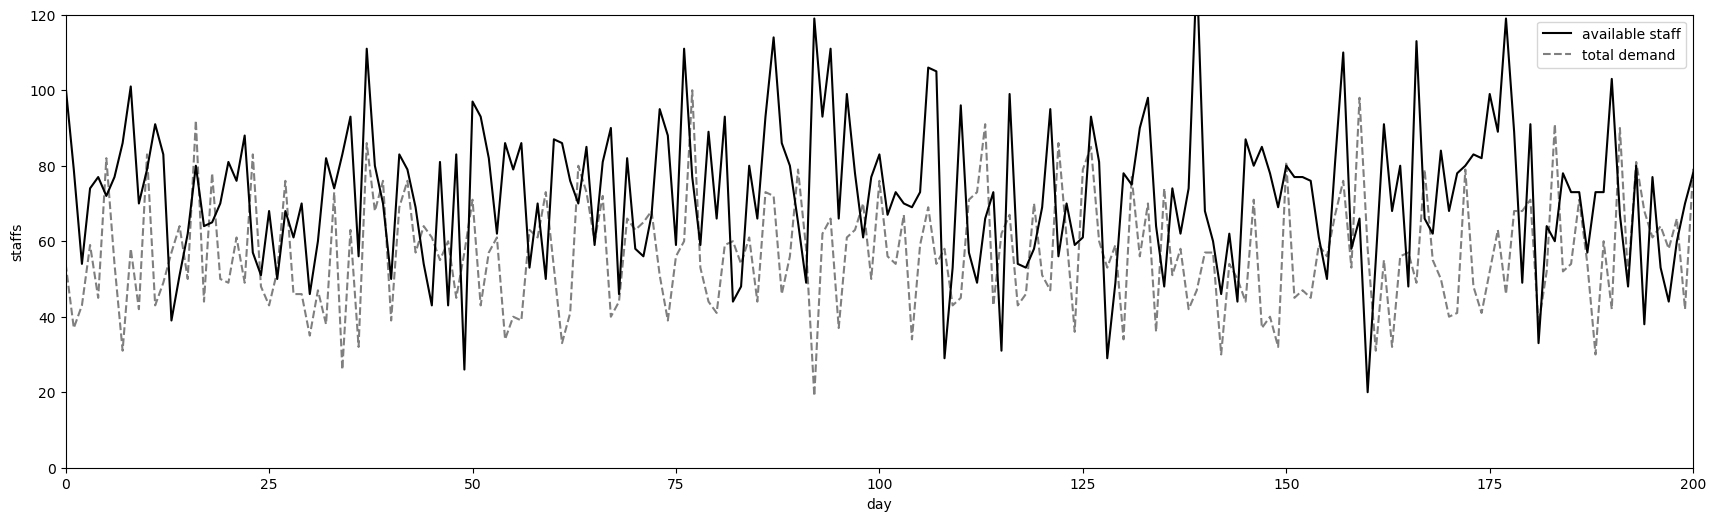

Mean staffs: 70.696
Mean staff demand: 56.637


In [14]:
samples_staff = []
samples_demand = []
for i in range(1000):
  input_data = create_input_data()
  samples_staff.append(input_data['total_staff'])
  samples_demand.append(sum(input_data['staff_needed_per_asset']))
figure(num=None, figsize=(21, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(samples_staff, 'black', label = 'available staff')
plt.plot(samples_demand,'k--',alpha=0.5,label = 'total demand')
plt.legend(loc='upper right')
plt.ylabel('staffs')
plt.xlabel('day')
plt.xlim([0,200])
plt.ylim([0,120])
plt.show()
print("Mean staffs:", sum(samples_staff)/1000)
print("Mean staff demand:", sum(samples_demand)/1000)

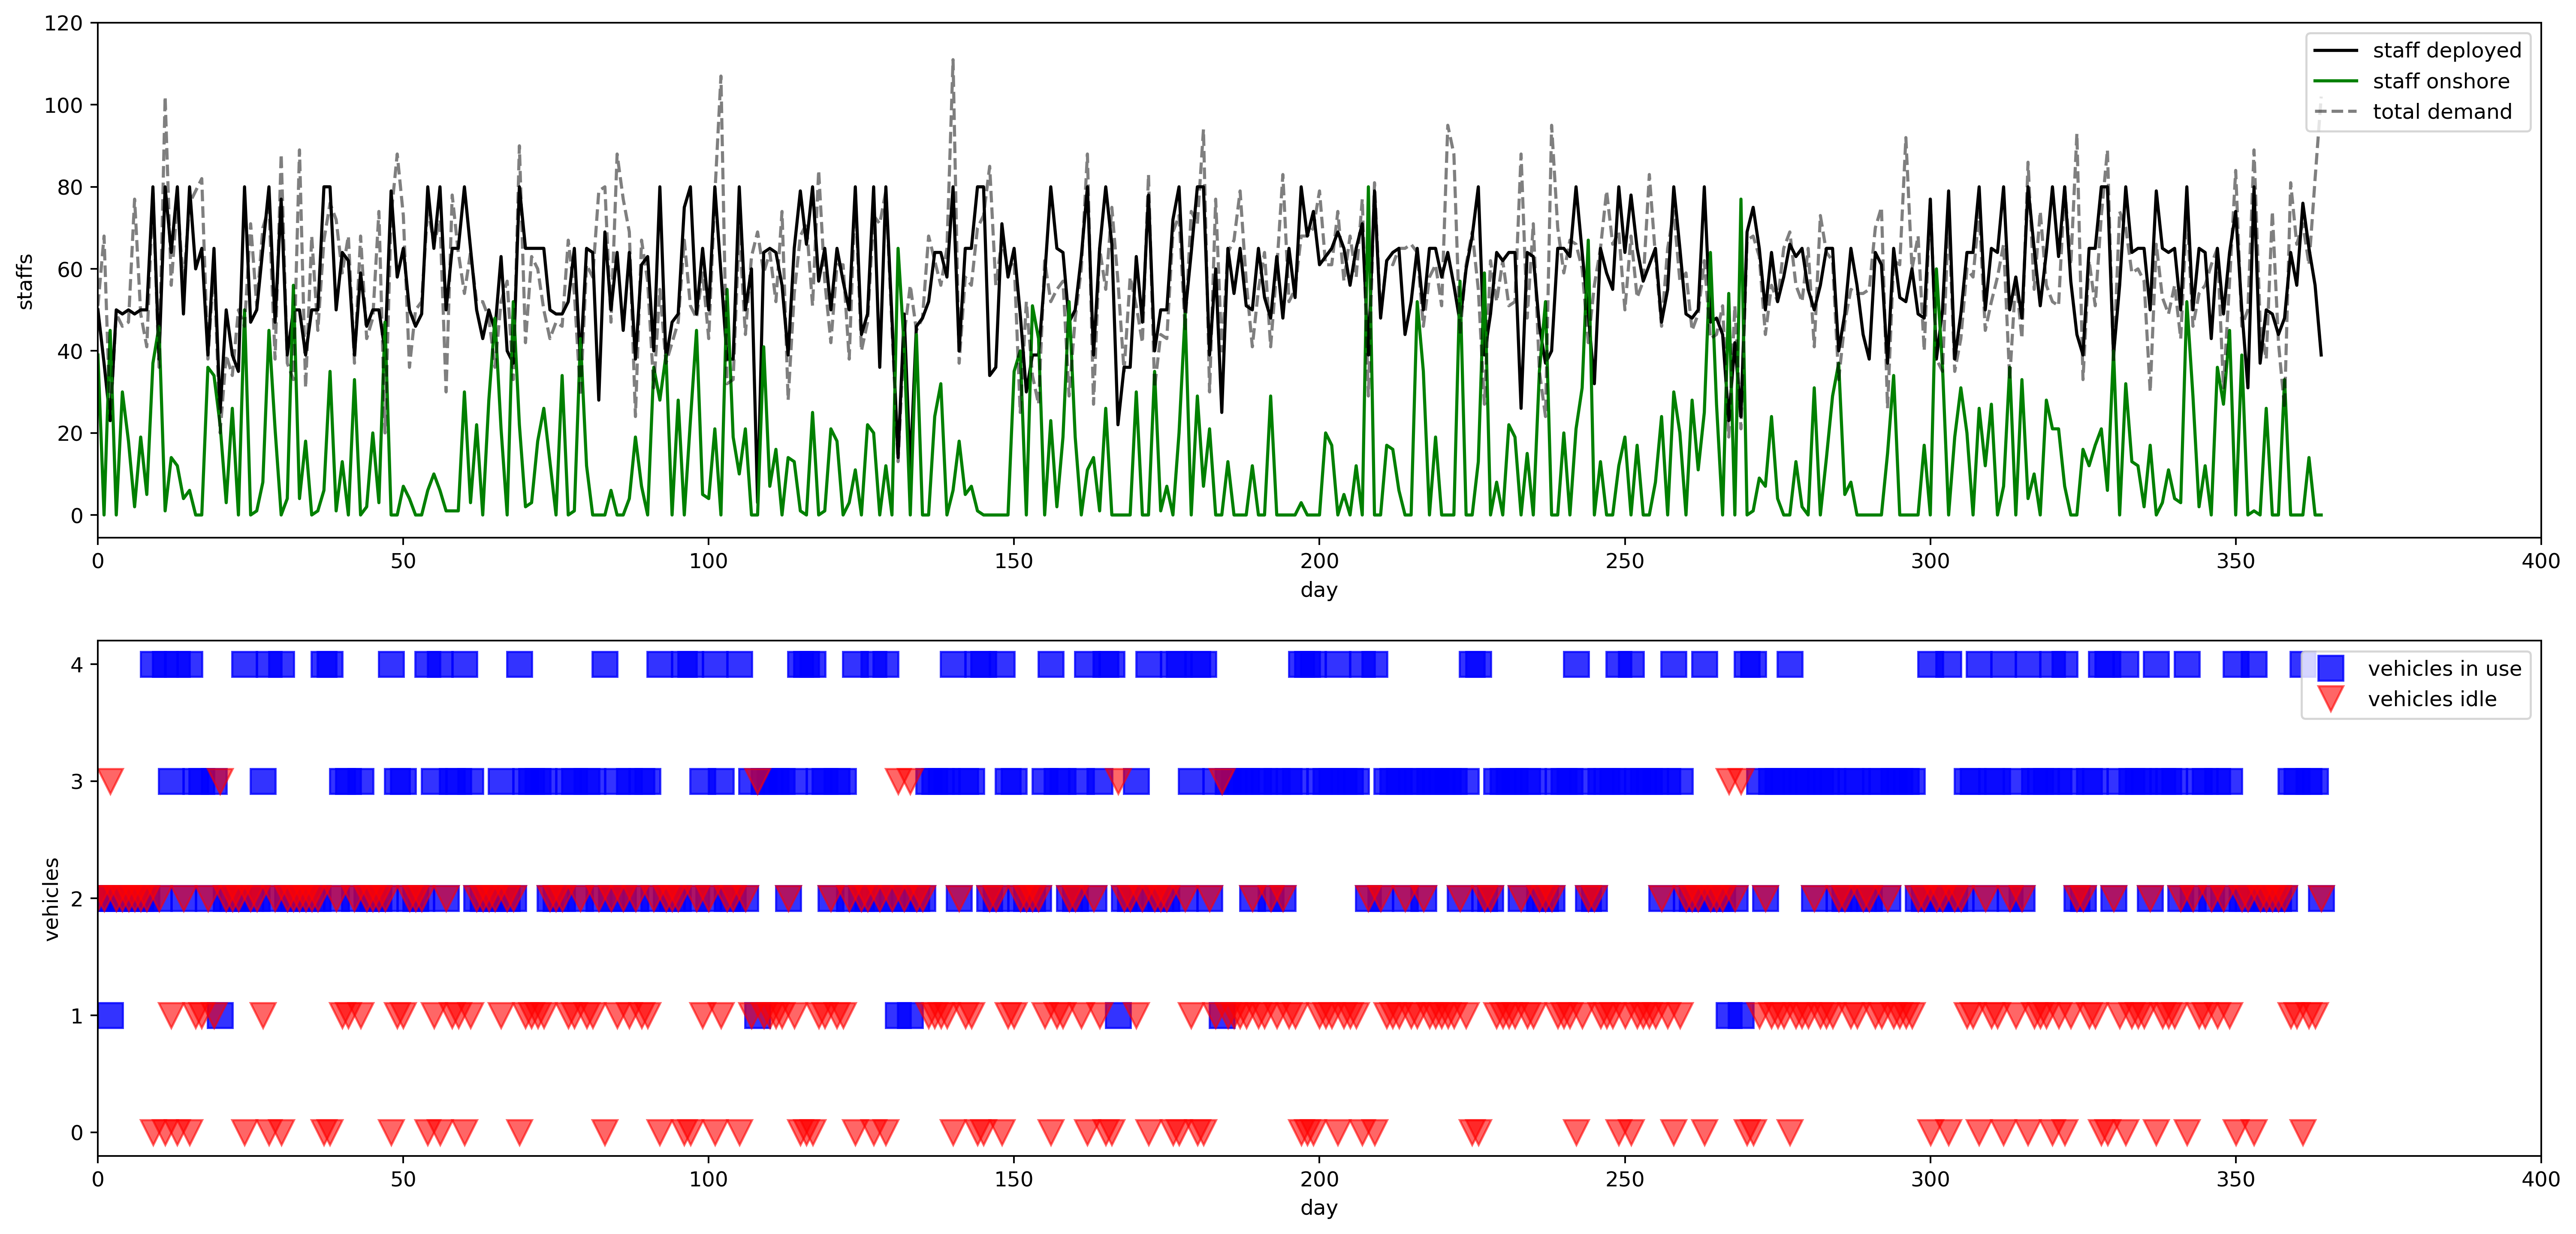

In [15]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(21,10), dpi=350)
ax1.plot(staff_deployed, 'k', label = 'staff deployed')
ax1.plot(staff_unused, 'g', label = 'staff onshore')
ax1.plot(total_demand,'k--', alpha=0.5, label = 'total demand')
ax1.legend(loc='upper right')
ax1.set_xlabel("day")
ax1.set_ylabel("staffs")
ax1.set_xlim([0,400])
ax1.set_yticks([0,20,40,60,80,100,120])
ax2.plot(vehicle_deployed,'bs',alpha=0.8,markersize=12, label = "vehicles in use")
ax2.plot(vehicle_idle,'rv',alpha =0.6,markersize=12, label = "vehicles idle")
ax2.set_xlabel("day")
ax2.set_ylabel("vehicles")
ax2.set_yticks([0,1,2,3,4])
ax2.set_xlim([0,400])
ax2.legend(loc='upper right')

No of days with idle vehicle: 295
capacity in use: [50, 40, 25, 50, 50, 50, 50, 50, 50, 80, 40, 80, 65, 80, 50, 80, 65, 65, 40, 65, 25, 50, 40, 40, 80, 50, 50, 65, 80, 50, 80, 40, 50, 50, 40, 50, 50, 80, 80, 50, 65, 65, 40, 65, 50, 50, 50, 40, 80, 65, 65, 50, 50, 50, 80, 65, 80, 50, 65, 65, 80, 65, 50, 50, 50, 50, 65, 40, 40, 80, 65, 65, 65, 65, 50, 50, 50, 65, 65, 40, 65, 65, 40, 80, 50, 65, 50, 65, 40, 65, 65, 40, 80, 40, 50, 50, 80, 80, 50, 65, 50, 80, 65, 40, 40, 80, 50, 65, 15, 65, 65, 65, 65, 40, 65, 80, 80, 80, 65, 65, 50, 65, 65, 50, 80, 50, 50, 80, 40, 80, 50, 15, 50, 15, 50, 50, 55, 65, 65, 65, 80, 40, 65, 65, 80, 80, 40, 40, 80, 65, 65, 50, 40, 40, 40, 65, 80, 65, 65, 50, 50, 65, 80, 40, 65, 80, 80, 25, 40, 40, 65, 50, 80, 40, 50, 50, 80, 80, 50, 65, 80, 80, 40, 65, 25, 65, 65, 65, 65, 50, 65, 55, 50, 65, 50, 65, 55, 80, 80, 80, 65, 65, 65, 80, 65, 65, 65, 80, 40, 80, 50, 65, 65, 65, 50, 55, 65, 50, 65, 65, 65, 65, 65, 50, 65, 80, 80, 40, 50, 65, 65, 65, 65, 40, 65, 65, 50, 

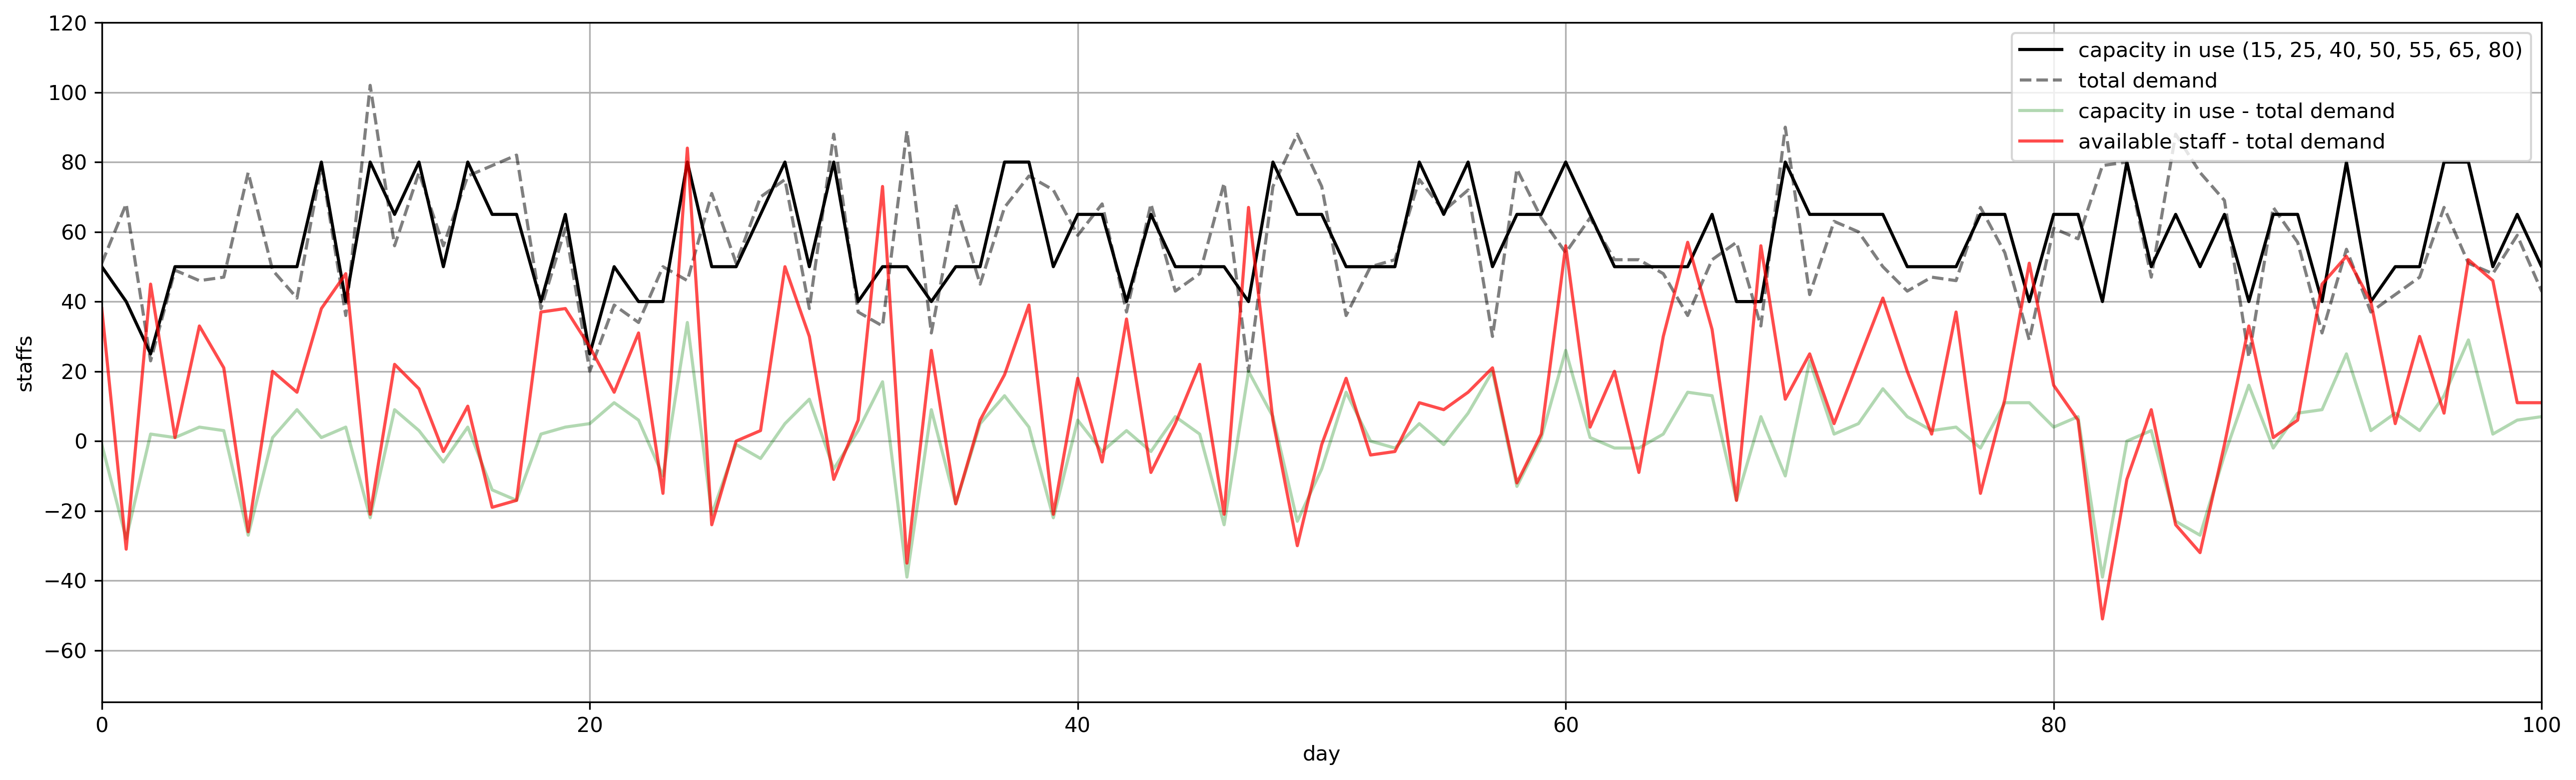

In [16]:
# # Key metrics
# Days with idle helicopters
days_idle_vehicle = 0
for i in range(len(vehicle_idle)):
  if(vehicle_idle[i]>0):
    days_idle_vehicle = days_idle_vehicle + 1
print("No of days with idle vehicle:", days_idle_vehicle)
# vehicle capacity in use
capacity_in_use = []
for i in range(len(selected_vehicles)):
  temp = 0
  for j in range(len(selected_vehicles[i])):
    if (selected_vehicles[i][j] >15):
      temp = temp+25
    else:
      temp = temp+15
  capacity_in_use.append(temp)
print("capacity in use:", capacity_in_use)

one_vehicle = 0 
two_vehicle = 0
three_vehicle = 0
for i in capacity_in_use:
  if (80 - i == 15 or 80-i==25):
    one_vehicle = one_vehicle + 1
  elif (80-i == 40 or 80 - i == 50 or 80-i==30):
    two_vehicle =two_vehicle +1
  elif(80- i == 65 or 80 - i == 55):
    three_vehicle = three_vehicle +1

print("One vehicle:", one_vehicle)
print("two vehicle:", two_vehicle)
print("three vehicle:", three_vehicle)

fig, (ax1) = plt.subplots(1,figsize=(21,6), dpi=300)
ax1.plot(capacity_in_use,'k', alpha=1, label = 'capacity in use (15, 25, 40, 50, 55, 65, 80)')
ax1.plot(total_demand, 'k--', alpha = 0.5, label = 'total demand')
ax1.plot([ x-y for x,y in zip(capacity_in_use,total_demand)], 'g', alpha = 0.3, label = 'capacity in use - total demand')
ax1.plot([ y-x for x,y in zip(total_demand,available_staff)], 'r', alpha = 0.7, label = 'available staff - total demand')
ax1.grid(True)
# ax1.plot(available_staff,'b--', alpha=0.8, label = 'available staff')

ax1.legend(loc='upper right')
ax1.set_xlabel("day")
ax1.set_ylabel("staffs")
ax1.set_xlim([0,100])
ax1.set_yticks([-60,-40,-20,0,20,40,60,80,100,120])
    
asset_priority = [1,1,2,2,2,1,1,2,1,1]
# Demand met at low production locations
demand_low = 0
demand_met_low = 0
demand_high = 0
demand_met_high = 0
for i in range(len(teams_composition)):
  for j in range(len(teams_composition[i])):
    if (demand_per_asset[i][j]>0):
      if (asset_priority[j] ==1):
        demand_low =demand_low+1
        if (sum(teams_composition[i][j])>=demand_per_asset[i][j]):
          demand_met_low  = demand_met_low + 1
      else:
        demand_high = demand_high + 1
        if (sum(teams_composition[i][j])>=demand_per_asset[i][j]):
          demand_met_high  = demand_met_high + 1
print("demand met low:", demand_met_low)
print("total demand low:", demand_low)
print("Percent demand met low:", demand_met_low*100/demand_low)
print("demand met high:", demand_met_high)
print("total demand high:", demand_high)
print("Percent demand met high:", demand_met_high*100/demand_high)

# team sent at low demand location
team_sent_low = 0
team_sent_high = 0
for i in range(len(teams_composition)):
  for j in range(len(teams_composition[i])):
    if (demand_per_asset[i][j]>0):
      if (asset_priority[j] ==1):
        if (sum(teams_composition[i][j])>0):
          team_sent_low  = team_sent_low + 1
      else:
        if (sum(teams_composition[i][j])>0):
          team_sent_high  = team_sent_high + 1
print("team sent low:", team_sent_low*100/demand_low)
print("team sent high:", team_sent_high*100/demand_high)


In [17]:
# days with demand is 2x the supply
demand_per_asset_rare = []
selected_vehicles_rare = []
teams_composition_rare = []
available_staff_rare = []
total_demand_rare = []
factor = 1.5
for i in range(len(available_staff)):
  if (total_demand[i]>factor*available_staff[i]):
    demand_per_asset_rare.append(demand_per_asset[i])
    selected_vehicles_rare.append(selected_vehicles[i])
    teams_composition_rare.append(teams_composition[i])
    available_staff_rare.append(available_staff[i])
    total_demand_rare.append(total_demand[i])

print(available_staff_rare)
print(total_demand_rare)
print(demand_per_asset_rare)
# print(selected_vehicles_rare)
print(teams_composition_rare)

[37, 51, 47, 54, 58, 28, 45, 59, 3, 36, 11, 34, 36, 30, 22, 36, 25, 48, 56, 26, 40, 32, 52, 44, 31, 49, 39]
[68, 77, 71, 89, 88, 79, 77, 107, 69, 71, 56, 85, 56, 52, 57, 58, 40, 83, 88, 88, 95, 56, 92, 93, 50, 74, 102]
[[0, 14, 6, 10, 13, 5, 3, 11, 4, 2], [6, 0, 10, 5, 0, 9, 8, 14, 14, 11], [3, 12, 11, 8, 9, 13, 0, 0, 0, 15], [3, 6, 13, 7, 8, 13, 9, 14, 12, 4], [8, 15, 13, 10, 12, 4, 2, 7, 11, 6], [11, 2, 5, 12, 15, 7, 4, 3, 9, 11], [0, 13, 10, 13, 13, 4, 0, 6, 8, 10], [0, 13, 9, 13, 15, 8, 15, 14, 11, 9], [5, 4, 7, 0, 9, 15, 9, 10, 10, 0], [0, 9, 10, 6, 7, 15, 6, 10, 2, 6], [0, 0, 5, 4, 14, 9, 0, 8, 1, 15], [5, 13, 10, 15, 7, 12, 1, 8, 0, 14], [1, 1, 10, 8, 0, 0, 9, 12, 12, 3], [12, 1, 12, 0, 12, 0, 15, 0, 0, 0], [7, 0, 15, 0, 0, 13, 0, 11, 4, 7], [3, 5, 0, 5, 6, 15, 8, 8, 8, 0], [0, 0, 0, 0, 11, 5, 10, 0, 3, 11], [3, 4, 8, 11, 9, 15, 14, 12, 2, 5], [7, 13, 12, 9, 15, 7, 10, 5, 7, 3], [14, 10, 12, 0, 11, 0, 11, 8, 13, 9], [15, 14, 10, 15, 0, 11, 9, 9, 5, 7], [0, 2, 11, 0, 9, 5, 7, 9, 

In [18]:
len(available_staff_rare)

27

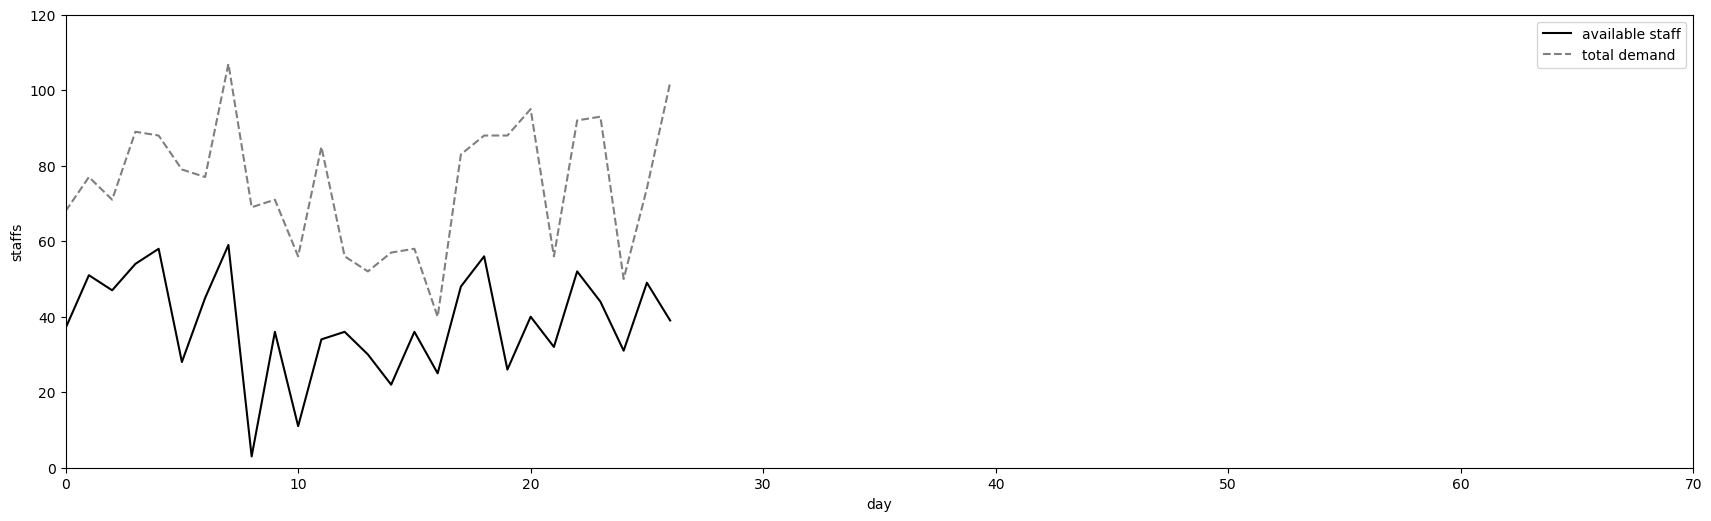

In [19]:
figure(num=None, figsize=(21, 6), dpi=100, facecolor='w', edgecolor='k')
plt.plot(available_staff_rare, 'black', label = 'available staff')
plt.plot(total_demand_rare,'k--',alpha=0.5,label = 'total demand')
plt.legend(loc='upper right')
plt.ylabel('staffs')
plt.xlabel('day')
plt.xlim([0,70])
plt.ylim([0,120])
plt.show()


In [20]:
# Demand met at low production locations
demand_low_rare = 0
demand_met_low_rare = 0
demand_high_rare = 0
demand_met_high_rare = 0
for i in range(len(teams_composition_rare)):
  for j in range(len(teams_composition_rare[i])):
    if (demand_per_asset_rare[i][j]>0):
      if (asset_priority[j] ==1):
        demand_low_rare =demand_low_rare+1
        if (sum(teams_composition_rare[i][j])>=demand_per_asset_rare[i][j]):
          demand_met_low_rare  = demand_met_low_rare + 1
      else:
        demand_high_rare = demand_high_rare + 1
        if (sum(teams_composition_rare[i][j])>=demand_per_asset_rare[i][j]):
          demand_met_high_rare  = demand_met_high_rare + 1
print("demand met low rare:", demand_met_low_rare)
print("total demand low rare:", demand_low_rare)
print("Percent demand met low rare:", demand_met_low_rare*100/demand_low_rare)
print("demand met high rare:", demand_met_high_rare)
print("total demand high rare:", demand_high_rare)
print("Percent demand met high rare:", demand_met_high_rare*100/demand_high_rare)


# team sent at low demand location
team_sent_low_rare = 0
team_sent_high_rare = 0
for i in range(len(teams_composition_rare)):
  for j in range(len(teams_composition_rare[i])):
    if (demand_per_asset_rare[i][j]>0):
      if (asset_priority[j] ==1):
        if (sum(teams_composition_rare[i][j])>0):
          team_sent_low_rare  = team_sent_low_rare + 1
      else:
        if (sum(teams_composition_rare[i][j])>0):
          team_sent_high_rare  = team_sent_high_rare + 1
print("team sent low rare:", team_sent_low_rare*100/demand_low_rare)
print("team sent high rare:", team_sent_high_rare*100/demand_high_rare)

demand met low rare: 38
total demand low rare: 130
Percent demand met low rare: 29.23076923076923
demand met high rare: 29
total demand high rare: 89
Percent demand met high rare: 32.58426966292135
team sent low rare: 92.3076923076923
team sent high rare: 93.25842696629213
